In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load Processed Data (feature engineering; 24h; aggregation)

In [3]:
df_agg = pd.read_csv('../../data/mimic_dataset_24h_aggregated.csv')
df_agg.head()

,gender,age,elixhauser,re_admission,Height_cm,Weight_kg,mechvent_mean,mechvent_max,extubated_mean,extubated_max,...,SOFA_min,SOFA_max,SOFA_std,SOFA_last,SIRS_mean,SIRS_min,SIRS_max,SIRS_std,SIRS_last,died_in_hosp
0,1,61,1,0,173.00,115.0,0.000000,0,0.0,0,...,13,13,NaN,13,1.000000,1,1,NaN,1,0
1,1,92,4,1,163.00,68.5,0.000000,0,0.0,0,...,2,8,2.225395,5,2.285714,1,4,0.951190,2,0
2,1,78,9,0,182.88,90.0,0.714286,1,0.0,0,...,5,8,0.975900,7,2.571429,2,3,0.534522,2,0
3,1,56,4,0,178.00,119.3,0.000000,0,0.0,0,...,8,9,0.534522,9,2.000000,0,3,1.000000,0,0
4,0,61,8,0,180.34,78.4,0.000000,0,0.0,0,...,9,11,0.707107,10,1.800000,1,2,0.447214,2,1


## 2. Define X and y

In [4]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])

## 3. Data Splitting  
- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (23248, 325)
Size of the testing set: (5812, 325)
Training set mortality rate: 0.165
Testing set mortality rate: 0.165


## 4. Missing Value Imputation

- For numerical features, using the median is often more robust than the mean, as it is not affected by outliers. For categorical features, the mode can be used. 
    
- The imputation values are calculated only on the training set and then applied to both the training and testing sets to prevent data leakage.

In [6]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std          0.087027
ETCO2_mean         0.056435
ETCO2_min          0.056435
ETCO2_max          0.056435
ETCO2_last         0.056435
                     ...   
Potassium_max      0.000000
Potassium_min      0.000000
Potassium_mean     0.000000
PAWplateau_last    0.000000
SIRS_last          0.000000
Length: 325, dtype: float64


In [7]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling    
    
Random Forest doesn't need feature scaling (tree-based models are scale-invariant)

## 6. Random Forest Training and Hyperparameter Tuning

In [ ]:
n_samples = len(y_train)
n_positive = (y_train == 1).sum()
n_negative = (y_train == 0).sum()
# class weights inversely proportional to class frequencies
# let model pay more attention to the minority class
class_weight_dict = {
    0: n_samples / (2 * n_negative),
    1: n_samples / (2 * n_positive)
}

print(f"Class weights: {class_weight_dict}")

rf_model = RandomForestClassifier(
    class_weight='balanced',  # Automatically handle class imbalance
    random_state=42,
    n_jobs=-1,                # Use all CPU cores
    oob_score=True            # Use out-of-bag samples for evaluation
)


Class weights: {0: 0.5985273672828382, 1: 3.037366083093807}


In [9]:
# Define the hyperparameter search space for Randomized Search
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True]
}

print("Using Random Search for hyperparameter tuning.")
print(f"Search space size: {len(param_distributions['n_estimators']) * len(param_distributions['max_depth']) * len(param_distributions['min_samples_split'])} combinations")

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=50,              # Randomly try 50 parameter combinations
    cv=5,                   # 5-fold cross-validation
    scoring='roc_auc',      # Use AUC as evaluation metric
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_imputed, y_train)

Using Random Search for hyperparameter tuning.
Search space size: 100 combinations
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1, oob_score=True,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['sqrt', 'log2', 0.3,
                                                         0.5],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [10]:
best_rf = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print(f"\nBest hyperparameters:")
for param, value in sorted(best_params.items()):
    print(f"  {param}: {value}")
print(f"Best cross-validation AUC: {best_cv_score:.4f}")
print(f"Out-of-bag (OOB) score: {best_rf.oob_score_:.4f}")


Best hyperparameters:
  bootstrap: True
  max_depth: 20
  max_features: 0.5
  min_samples_leaf: 8
  min_samples_split: 10
  n_estimators: 300
Best cross-validation AUC: 0.8410
Out-of-bag (OOB) score: 0.8591


## 7. Model Evaluation

In [11]:
y_train_pred = best_rf.predict(X_train_imputed)
y_test_pred = best_rf.predict(X_test_imputed)
y_train_proba = best_rf.predict_proba(X_train_imputed)[:, 1]
y_test_proba = best_rf.predict_proba(X_test_imputed)[:, 1]

# Training set performance
print("Training set performance:")
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = best_rf.score(X_train_imputed, y_train)
print(f"  AUC-ROC: {train_auc:.4f}")
print(f"  Accuracy: {train_acc:.4f}")

# Test set performance
print("\nTest set performance:")
test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = best_rf.score(X_test_imputed, y_test)
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  Accuracy: {test_acc:.4f}")


Training set performance:
  AUC-ROC: 0.9974
  Accuracy: 0.9845

Test set performance:
  AUC-ROC: 0.8554
  Accuracy: 0.8637


In [12]:
# Overfitting check
print(f"\nOverfitting analysis:")
print(f"  Train-Test AUC difference: {(train_auc - test_auc):.4f}")
if train_auc - test_auc < 0.05:
    print(f"Low overfitting (difference < 0.05)")
elif train_auc - test_auc < 0.10:
    print(f"Mild overfitting (difference 0.05-0.10)")
else:
    print(f"Significant overfitting (difference > 0.10)")

# Confusion matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"  True Negative (TN): {cm[0,0]}, False Positive (FP): {cm[0,1]}")
print(f"  False Negative (FN): {cm[1,0]}, True Positive (TP): {cm[1,1]}")

# Calculate additional metrics
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # Recall/Sensitivity
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity
precision = cm[1,1] / (cm[1,1] + cm[0,1])    # Precision
npv = cm[0,0] / (cm[0,0] + cm[1,0])          # Negative Predictive Value

print(f"\nDetailed Performance Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.3f}")
print(f"  Specificity: {specificity:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Negative Predictive Value (NPV): {npv:.3f}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Survived', 'Died']))



Overfitting analysis:
  Train-Test AUC difference: 0.1419
Significant overfitting (difference > 0.10)

Confusion Matrix (Test Set):
[[4619  236]
 [ 556  401]]
  True Negative (TN): 4619, False Positive (FP): 236
  False Negative (FN): 556, True Positive (TP): 401

Detailed Performance Metrics:
  Sensitivity (Recall): 0.419
  Specificity: 0.951
  Precision: 0.630
  Negative Predictive Value (NPV): 0.893

Classification Report (Test Set):
              precision    recall  f1-score   support

    Survived       0.89      0.95      0.92      4855
        Died       0.63      0.42      0.50       957

    accuracy                           0.86      5812
   macro avg       0.76      0.69      0.71      5812
weighted avg       0.85      0.86      0.85      5812



## 8. Feature Importance Analysis

In [13]:
# Random Forest feature importance (based on mean impurity decrease)
feature_names = X.columns.tolist()
feature_importance = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
for i, row in importance_df.head(20).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.6f}")

# Cumulative importance analysis
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
n_features_90 = (importance_df['cumulative_importance'] <= 0.90).sum()
n_features_95 = (importance_df['cumulative_importance'] <= 0.95).sum()

print(f"\nCumulative Feature Importance Analysis:")
print(f"  Top {n_features_90} features contribute 90% of importance")
print(f"  Top {n_features_95} features contribute 95% of importance")
print(f"  Total number of features: {len(feature_names)}")


Top 20 Most Important Features:
SOFA_mean                     : 0.064587
GCS_last                      : 0.034609
SOFA_last                     : 0.030768
output_step_mean              : 0.025725
RASS_last                     : 0.024597
FiO2_100_last                 : 0.021321
age                           : 0.019796
FiO2_1_last                   : 0.018378
output_step_max               : 0.013269
BUN_last                      : 0.012360
median_dose_vaso_last         : 0.011695
elixhauser                    : 0.010841
SIRS_mean                     : 0.009755
Shock_Index_last              : 0.009580
Arterial_lactate_last         : 0.009088
Arterial_lactate_mean         : 0.008926
output_total_std              : 0.008407
SOFA_min                      : 0.008316
max_dose_vaso_last            : 0.008120
RASS_mean                     : 0.007825

Cumulative Feature Importance Analysis:
  Top 239 features contribute 90% of importance
  Top 272 features contribute 95% of importance
  Total nu

## 9. Visualization

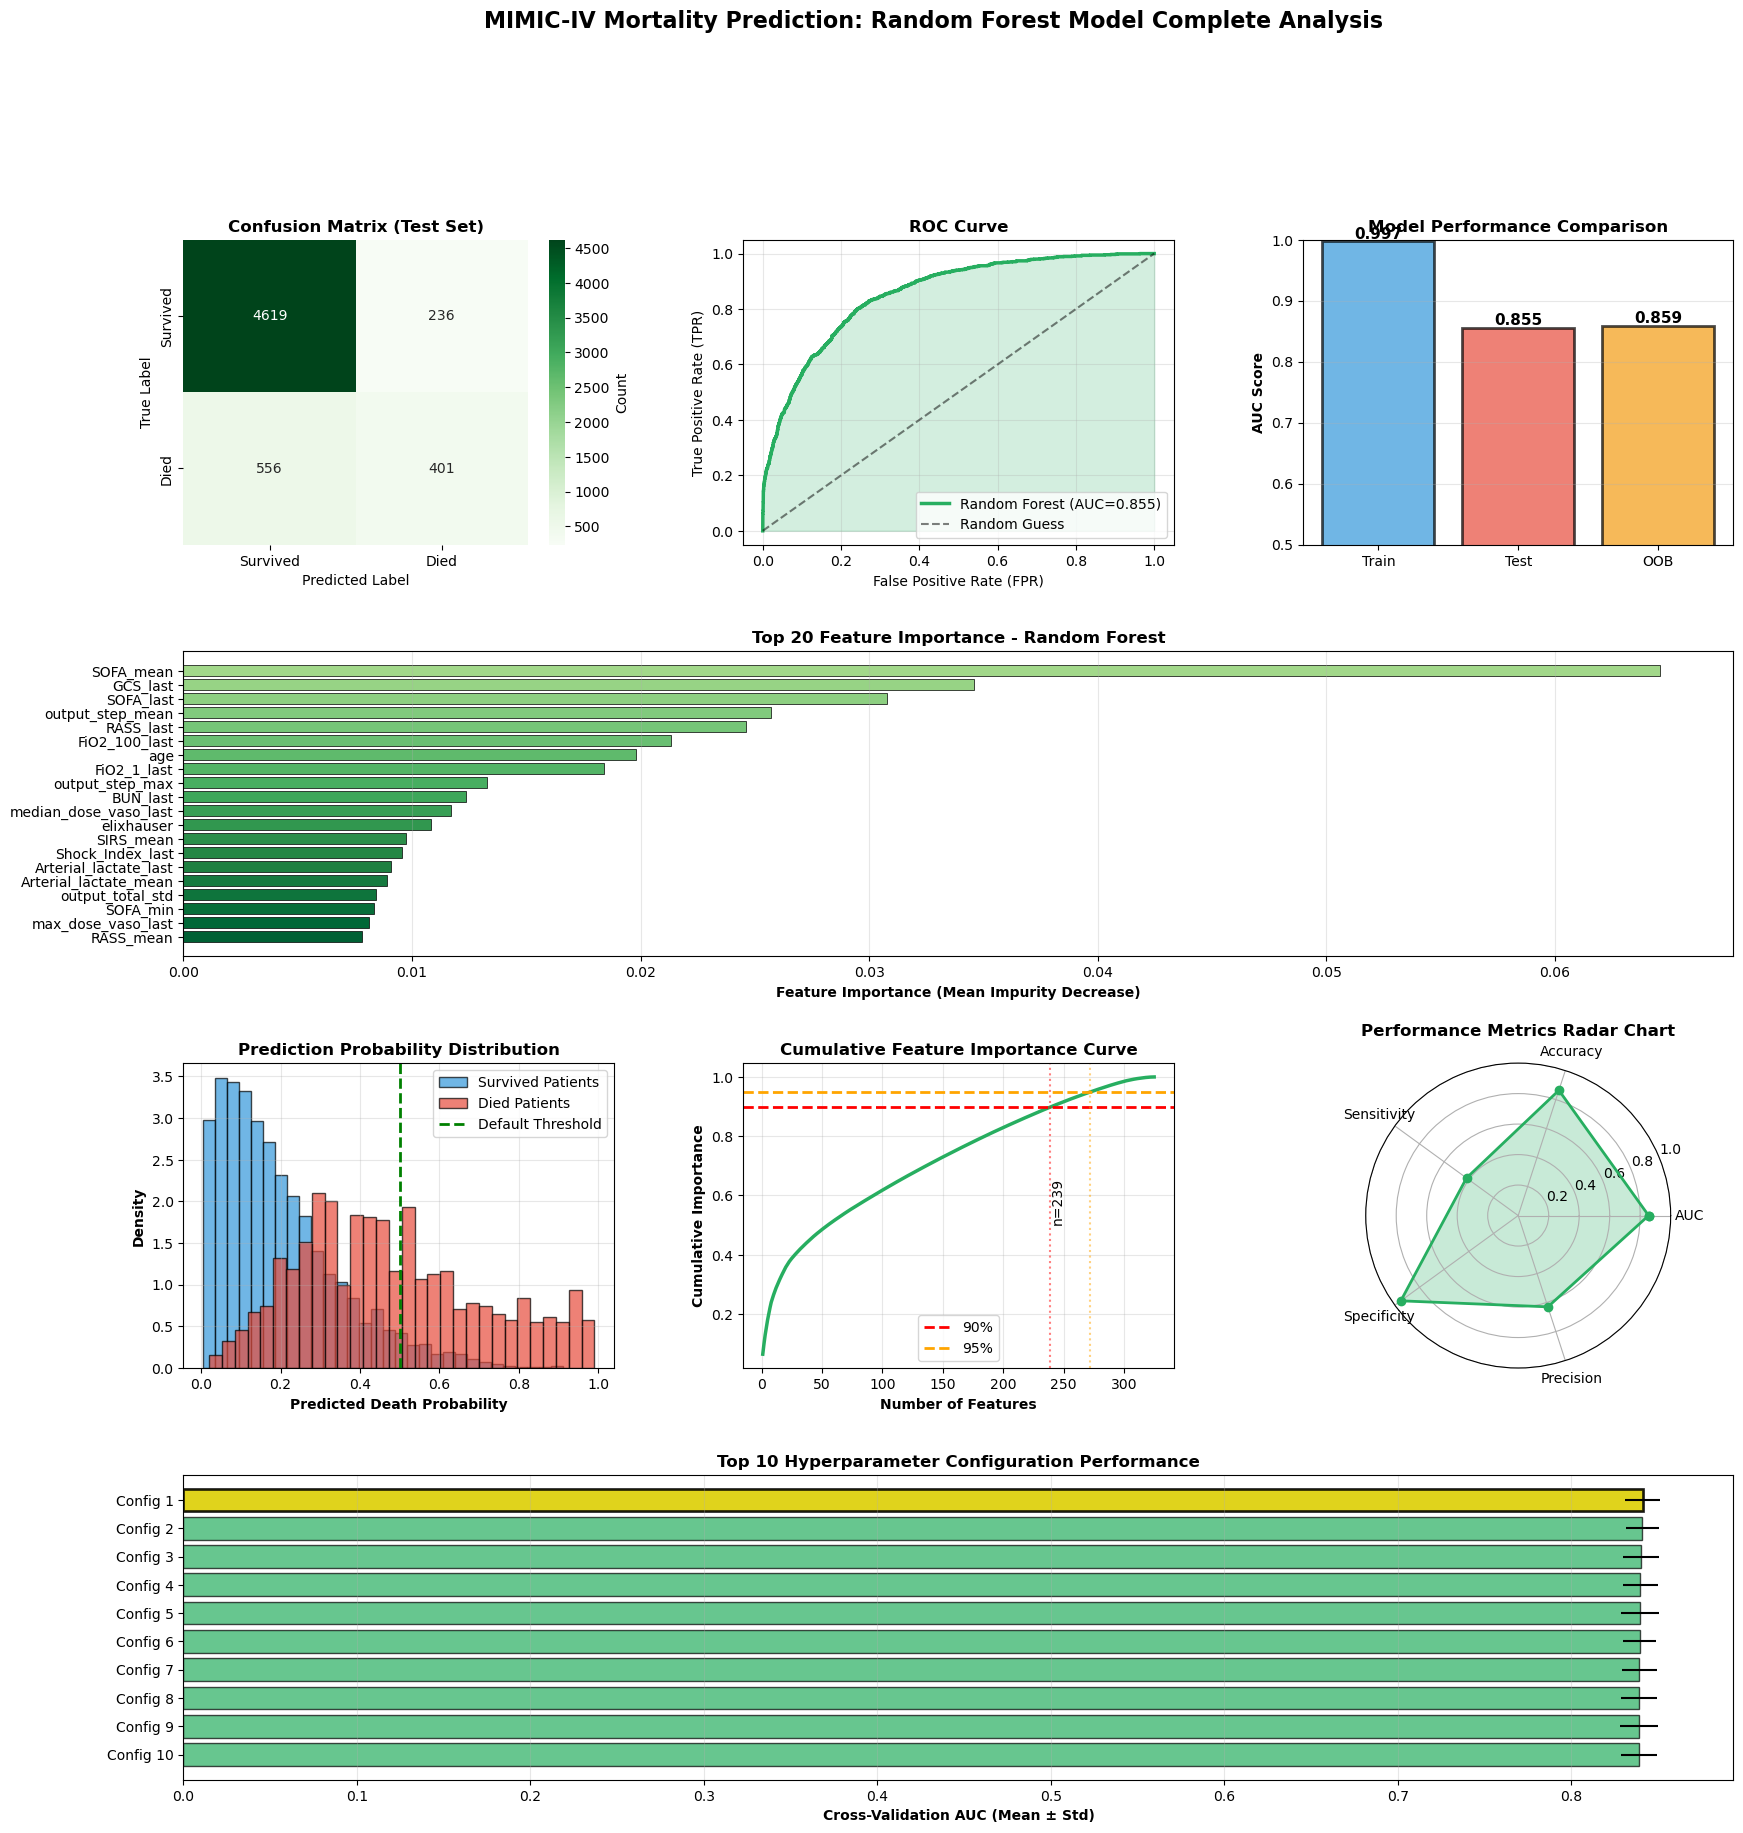

In [15]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax1,
            xticklabels=['Survived', 'Died'], 
            yticklabels=['Survived', 'Died'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
ax2.plot(fpr, tpr, label=f'Random Forest (AUC={test_auc:.3f})', 
         linewidth=2.5, color='#27ae60')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax2.fill_between(fpr, tpr, alpha=0.2, color='#27ae60')
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Train vs Test vs OOB Comparison
ax3 = fig.add_subplot(gs[0, 2])
scores = [train_auc, test_auc, best_rf.oob_score_]
labels = ['Train', 'Test', 'OOB']
colors = ['#3498db', '#e74c3c', '#f39c12']
bars = ax3.bar(labels, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('AUC Score', fontweight='bold')
ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0.5, 1.0])
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Top 20 Feature Importance
ax4 = fig.add_subplot(gs[1, :])
top20 = importance_df.head(20)
colors_feat = plt.cm.YlGn(np.linspace(0.4, 0.9, len(top20)))
bars = ax4.barh(range(len(top20)), top20['importance'], color=colors_feat, 
                edgecolor='black', linewidth=0.5)
ax4.set_yticks(range(len(top20)))
ax4.set_yticklabels(top20['feature'])
ax4.set_xlabel('Feature Importance (Mean Impurity Decrease)', fontweight='bold')
ax4.set_title('Top 20 Feature Importance - Random Forest', 
              fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, axis='x', alpha=0.3)

# 5. Prediction Probability Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='Survived Patients', density=True, color='#3498db', edgecolor='black')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='Died Patients', density=True, color='#e74c3c', edgecolor='black')
ax5.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Default Threshold')
ax5.set_xlabel('Predicted Death Probability', fontweight='bold')
ax5.set_ylabel('Density', fontweight='bold')
ax5.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Cumulative Feature Importance
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(range(1, len(importance_df)+1), 
         importance_df['cumulative_importance'].values,
         linewidth=2.5, color='#27ae60')
ax6.axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90%')
ax6.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95%')
ax6.axvline(x=n_features_90, color='red', linestyle=':', alpha=0.5)
ax6.axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.5)
ax6.set_xlabel('Number of Features', fontweight='bold')
ax6.set_ylabel('Cumulative Importance', fontweight='bold')
ax6.set_title('Cumulative Feature Importance Curve', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.text(n_features_90, 0.5, f'n={n_features_90}', rotation=90, va='bottom')

# 7. Performance Metrics Radar Chart
ax7 = fig.add_subplot(gs[2, 2], projection='polar')
categories = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision']
values = [test_auc, test_acc, sensitivity, specificity, precision]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]
ax7.plot(angles, values, 'o-', linewidth=2, color='#27ae60')
ax7.fill(angles, values, alpha=0.25, color='#27ae60')
ax7.set_xticks(angles[:-1])
ax7.set_xticklabels(categories)
ax7.set_ylim(0, 1)
ax7.set_title('Performance Metrics Radar Chart', fontsize=12, fontweight='bold', pad=20)
ax7.grid(True)

# 8. Hyperparameter Tuning Results
ax8 = fig.add_subplot(gs[3, :])
cv_results = pd.DataFrame(random_search.cv_results_)
top_10_results = cv_results.nlargest(10, 'mean_test_score')

x_pos = np.arange(len(top_10_results))
ax8.barh(x_pos, top_10_results['mean_test_score'], 
         xerr=top_10_results['std_test_score'],
         color='#27ae60', alpha=0.7, edgecolor='black')
ax8.set_yticks(x_pos)
ax8.set_yticklabels([f"Config {i+1}" for i in range(len(top_10_results))])
ax8.set_xlabel('Cross-Validation AUC (Mean ± Std)', fontweight='bold')
ax8.set_title('Top 10 Hyperparameter Configuration Performance', fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(True, axis='x', alpha=0.3)

# Highlight best configuration
best_idx = top_10_results.index[0]
ax8.barh(0, top_10_results['mean_test_score'].iloc[0], 
         color='gold', alpha=0.8, edgecolor='black', linewidth=2)

plt.suptitle('MIMIC-IV Mortality Prediction: Random Forest Model Complete Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()